# Prerequisites

In [1]:
import librosa
import librosa.display
import numpy as np
from matplotlib import pyplot as plt
from openTSNE import TSNE
from openTSNE.callbacks import ErrorLogger
from umap import UMAP
import pandas as pd
from scipy import interpolate
import soundfile as sf
from skimage.util.shape import view_as_windows

In [2]:
def standardize(data, axis=None):
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True)
    return (data - mean) / std

# Data Import & Settings

In [3]:
song, sr = librosa.load('starless.wav', sr=22050, mono=False)
left, right = song

In [4]:
frame_len = 2**15
step_len = 2**13
print('''
    Frame size:\t{n_frame:6d} samples equiv. to {t_frame:1.2f} seconds
    Step size:\t{n_step:6d} samples equiv. to {t_step:1.2f} seconds
    '''.format(
    n_frame=frame_len,
    t_frame=frame_len/sr,
    n_step=step_len,
    t_step=step_len/sr
))


    Frame size:	 32768 samples equiv. to 1.49 seconds
    Step size:	  8192 samples equiv. to 0.37 seconds
    


# Feature Extraction

## MFCC

In [5]:
mfcc = {}
mfcc['left'] = librosa.feature.mfcc(left,
    n_mfcc=20,
    sr=sr,
    n_fft=frame_len,
    hop_length=step_len,
    center=False
)
mfcc['right'] = librosa.feature.mfcc(right,
    n_mfcc=20,
    sr=sr,
    n_fft=frame_len,
    hop_length=step_len,
    center=False
)

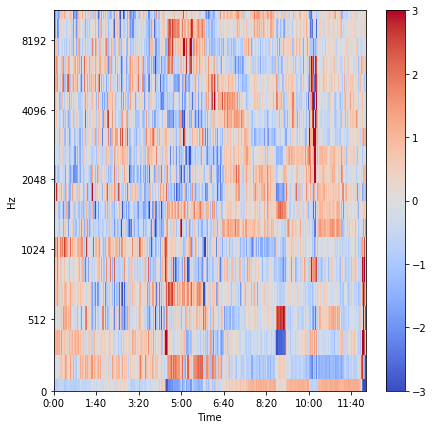

In [6]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
img = librosa.display.specshow(standardize(mfcc['left'], axis=1),
    y_axis='mel',
    x_axis='time',
    ax=ax,
    sr=sr,
    hop_length=step_len,
    vmin=-3,
    vmax=3
)
fig.colorbar(img, ax=ax)

## Chroma

In [52]:
chroma = {}
chroma['left'] = librosa.feature.chroma_cens(left,
    sr=sr,
    n_chroma=12,
    #n_fft=frame_len,
    hop_length=step_len,
    #center=False,
    win_len_smooth=10
)
chroma['right'] = librosa.feature.chroma_cens(right,
    sr=sr,
    n_chroma=12,
    #n_fft=frame_len,
    hop_length=step_len,
    #center=False,
    win_len_smooth=10
)

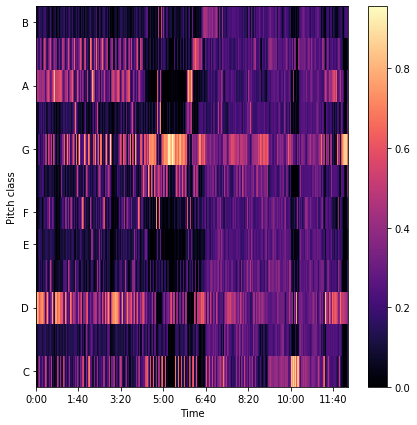

In [53]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
img = librosa.display.specshow(chroma['left'],
    y_axis='chroma',
    x_axis='time',
    ax=ax,
    sr=sr,
    hop_length=step_len
)
fig.colorbar(img, ax=ax)

# Embedding

## MFCC

In [9]:
mfcc_std = standardize(np.hstack([mfcc['left'], mfcc['right']]), axis=1).transpose()
tsne = TSNE(perplexity=250, callbacks=ErrorLogger())
emb_mfcc = tsne.fit(mfcc_std)

Iteration   50, KL divergence  2.5901, 50 iterations in 2.8198 sec
Iteration  100, KL divergence  2.5901, 50 iterations in 2.6370 sec
Iteration  150, KL divergence  2.5901, 50 iterations in 2.6845 sec
Iteration  200, KL divergence  2.5901, 50 iterations in 2.7353 sec
Iteration  250, KL divergence  2.5901, 50 iterations in 2.6215 sec
Iteration   50, KL divergence  1.0974, 50 iterations in 2.6512 sec
Iteration  100, KL divergence  0.9335, 50 iterations in 2.6347 sec
Iteration  150, KL divergence  0.8813, 50 iterations in 2.6661 sec
Iteration  200, KL divergence  0.8576, 50 iterations in 2.6326 sec
Iteration  250, KL divergence  0.8464, 50 iterations in 2.6736 sec
Iteration  300, KL divergence  0.8411, 50 iterations in 2.7531 sec
Iteration  350, KL divergence  0.8382, 50 iterations in 2.6413 sec
Iteration  400, KL divergence  0.8365, 50 iterations in 2.6085 sec
Iteration  450, KL divergence  0.8355, 50 iterations in 2.6257 sec
Iteration  500, KL divergence  0.8342, 50 iterations in 2.6576

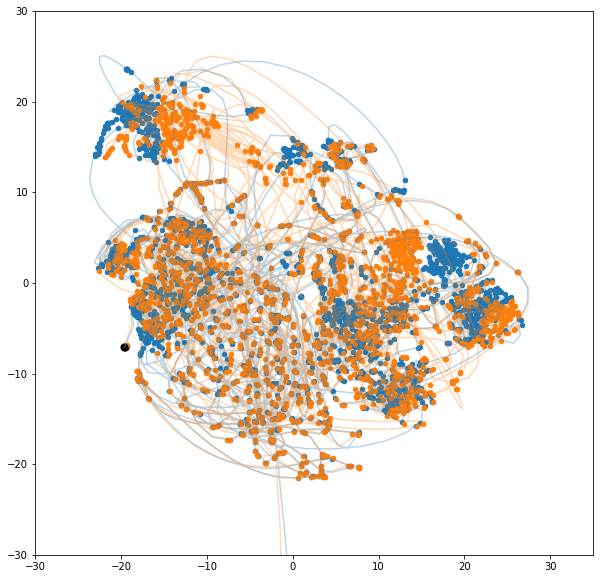

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
embedding=[emb_mfcc[:mfcc['left'].shape[1]], emb_mfcc[mfcc['left'].shape[1]:]]
for idx, story in enumerate(embedding):
    tck, u = interpolate.splprep((story + (1e-6*np.random.rand(*(story.shape)))).transpose(), s=0)
    unew = np.arange(0, 1.01, 0.0005)
    out = interpolate.splev(unew, tck)
    ax.scatter(story[:,0], story[:,1], s=20)
    ax.scatter(story[:1,0], story[:1,1], s=50, color='black')
    ax.plot(out[0], out[1], alpha=0.3)
plt.xlim([-30,35]);
plt.ylim([-30,30]);

## Chroma

In [54]:
tsne = TSNE(perplexity=250, callbacks=ErrorLogger())
emb_chroma = tsne.fit(np.hstack([chroma['left'], chroma['right']]).transpose())

Iteration   50, KL divergence  2.5995, 50 iterations in 2.5314 sec
Iteration  100, KL divergence  2.5127, 50 iterations in 2.4605 sec
Iteration  150, KL divergence  2.5114, 50 iterations in 2.4577 sec
Iteration  200, KL divergence  2.5066, 50 iterations in 2.4834 sec
Iteration  250, KL divergence  2.5024, 50 iterations in 2.4640 sec
Iteration   50, KL divergence  0.8290, 50 iterations in 2.4744 sec
Iteration  100, KL divergence  0.7155, 50 iterations in 2.4674 sec
Iteration  150, KL divergence  0.6790, 50 iterations in 2.5201 sec
Iteration  200, KL divergence  0.6645, 50 iterations in 2.4535 sec
Iteration  250, KL divergence  0.6582, 50 iterations in 2.4751 sec
Iteration  300, KL divergence  0.6553, 50 iterations in 2.4735 sec
Iteration  350, KL divergence  0.6534, 50 iterations in 2.4753 sec
Iteration  400, KL divergence  0.6527, 50 iterations in 2.4606 sec
Iteration  450, KL divergence  0.6522, 50 iterations in 2.5083 sec
Iteration  500, KL divergence  0.6519, 50 iterations in 2.6323

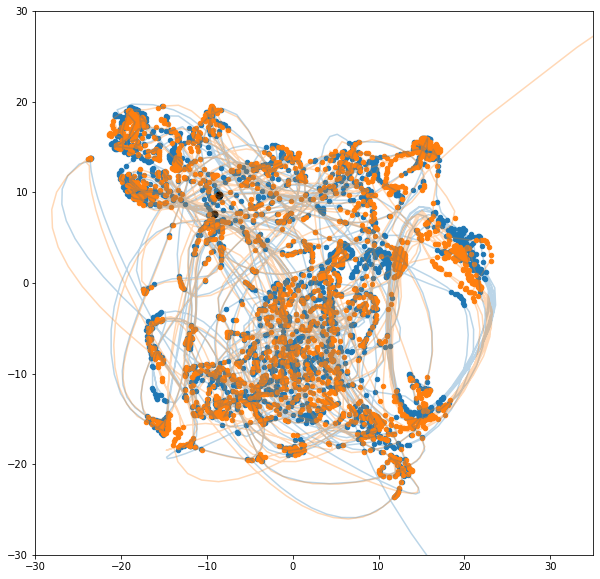

In [55]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
embedding=[emb_chroma[:chroma['left'].shape[1]], emb_chroma[chroma['left'].shape[1]:]]
for idx, story in enumerate(embedding):
    tck, u = interpolate.splprep((story + (1e-6*np.random.rand(*(story.shape)))).transpose(), s=3)
    unew = np.arange(0, 1.01, 0.0005)
    out = interpolate.splev(unew, tck)
    ax.scatter(story[:,0], story[:,1], s=20)
    ax.scatter(story[:1,0], story[:1,1], s=50, color='black')
    ax.plot(out[0], out[1], alpha=0.3)
plt.xlim([-30,35]);
plt.ylim([-30,30]);

# Export

In [56]:
df = pd.DataFrame()
df['line'] = np.concatenate([
    np.full(mfcc['left'].shape[1], 0),
    np.full(mfcc['right'].shape[1], 1)
])
df['algo'] = df['line']
df['x'] = emb_mfcc[:,0]
df['y'] = emb_mfcc[:,1]
df['t_start'] = np.concatenate([
    np.arange(0,mfcc['left'].shape[1], 1) * step_len / sr,
    np.arange(0,mfcc['left'].shape[1], 1) * step_len / sr
])
df['t_end'] = df['t_start']  + (frame_len / sr)
df = pd.concat([
    df,
    pd.DataFrame.from_records(
        np.hstack([
            mfcc['left'],
            mfcc['right']
        ]).transpose(),
        columns=['mfcc{:02d}'.format(i+1) for i in range(20)]
    )],
    axis=1
)

In [57]:
df.to_csv('starless_mfcc.csv', index=False)

In [59]:
df = pd.DataFrame()
df['line'] = np.concatenate([
    np.full(chroma['left'].shape[1], 0),
    np.full(chroma['right'].shape[1], 1)
])
df['algo'] = df['line']
df['x'] = emb_chroma[:,0]
df['y'] = emb_chroma[:,1]
df['t_start'] = np.concatenate([
    np.arange(0,chroma['left'].shape[1], 1) * step_len / sr,
    np.arange(0,chroma['left'].shape[1], 1) * step_len / sr
])
df['t_end'] = df['t_start']  + (frame_len / sr)
df = pd.concat([
    df,
    pd.DataFrame.from_records(
        np.hstack([
            chroma['left'],
            chroma['right']
        ]).transpose(),
        columns=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    )],
    axis=1
)

In [60]:
df.to_csv('starless_chroma.csv', index=False)

In [93]:
frames = np.stack([
    view_as_windows(left, frame_len, step_len),
    view_as_windows(right, frame_len, step_len)
]).transpose(1,2,0)

In [101]:
for i, fr in enumerate(frames):
    filename = 'frames/frame-{:04d}.wav'.format(i)
    sf.write(filename, fr, sr, format='WAV')